In [ ]:
# Time Series Analysis

In [ ]:
# Author: Avisheka Guha Niyogi

In [23]:
# Importing Libraries

import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from scipy.stats import ttest_ind
from statsmodels.stats import weightstats as stests
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import warnings
warnings.filterwarnings("ignore")
# stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

In [6]:
# Importing data

ds=pd.read_excel(r"C:\Users\hp\LearnBayAIML\PythonCodes\Projects\Time-Series\yen.xlsx")

In [7]:
# Analysing data

ds.head()

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
0,1976-08-02,3398,3401,3398,3401,NaN,3401,2,1
1,1976-08-03,3401,3401,3401,3401,NaN,3401,0,1
2,1976-08-04,3401,3401,3401,3401,NaN,3401,0,1
3,1976-08-05,3401,3401,3401,3401,NaN,3401,0,1
4,1976-08-06,3401,3401,3401,3401,NaN,3401,0,1


In [8]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10902 entries, 0 to 10901
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        10902 non-null  datetime64[ns]
 1   Open                        10902 non-null  int64         
 2   High                        10902 non-null  int64         
 3   Low                         10902 non-null  int64         
 4   Last                        10902 non-null  int64         
 5   Change                      1415 non-null   float64       
 6   Settle                      10902 non-null  int64         
 7   Volume                      10902 non-null  int64         
 8   Previous Day Open Interest  10902 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 766.7 KB


In [9]:
ds.isna().sum()

Date                             0
Open                             0
High                             0
Low                              0
Last                             0
Change                        9487
Settle                           0
Volume                           0
Previous Day Open Interest       0
dtype: int64

In [10]:
# Trim the dataset to begin on January 1st, 1990
yf = ds.loc["1990-01-01":, :]
yf.head()

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
1991,1984-06-25,4253,4263,4249,4252,NaN,4252,5463,15293
1992,1984-06-26,4278,4283,4269,4278,NaN,4278,5435,14945
1993,1984-06-27,4263,4282,4251,4267,NaN,4267,7103,14480
1994,1984-06-28,4261,4275,4251,4264,NaN,4264,5423,14484
1995,1984-06-29,4274,4279,4262,4265,NaN,4265,3029,14622


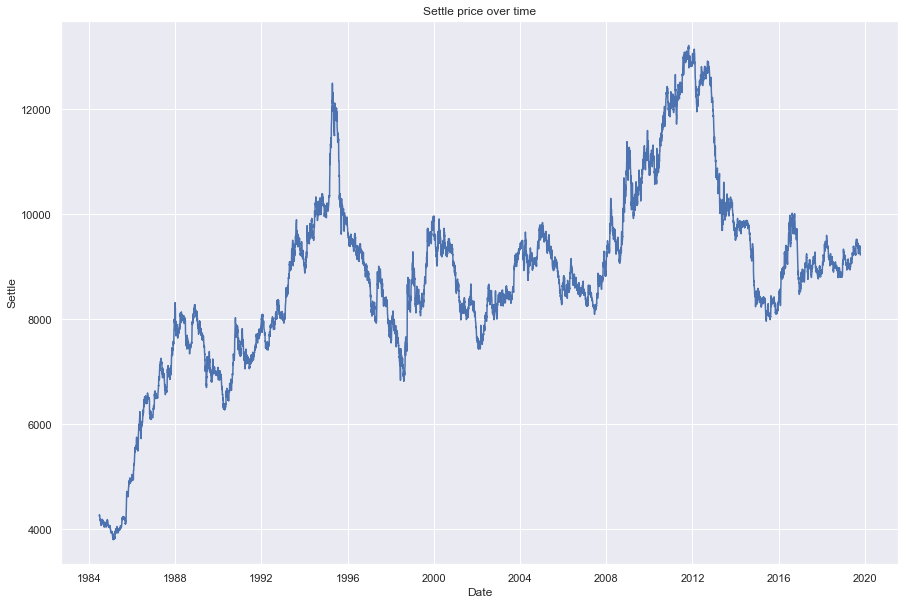

In [11]:
# Settle price over years

sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(x='Date', 
             y='Settle', data=yf)
plt.title("Settle price over time")
plt.show()

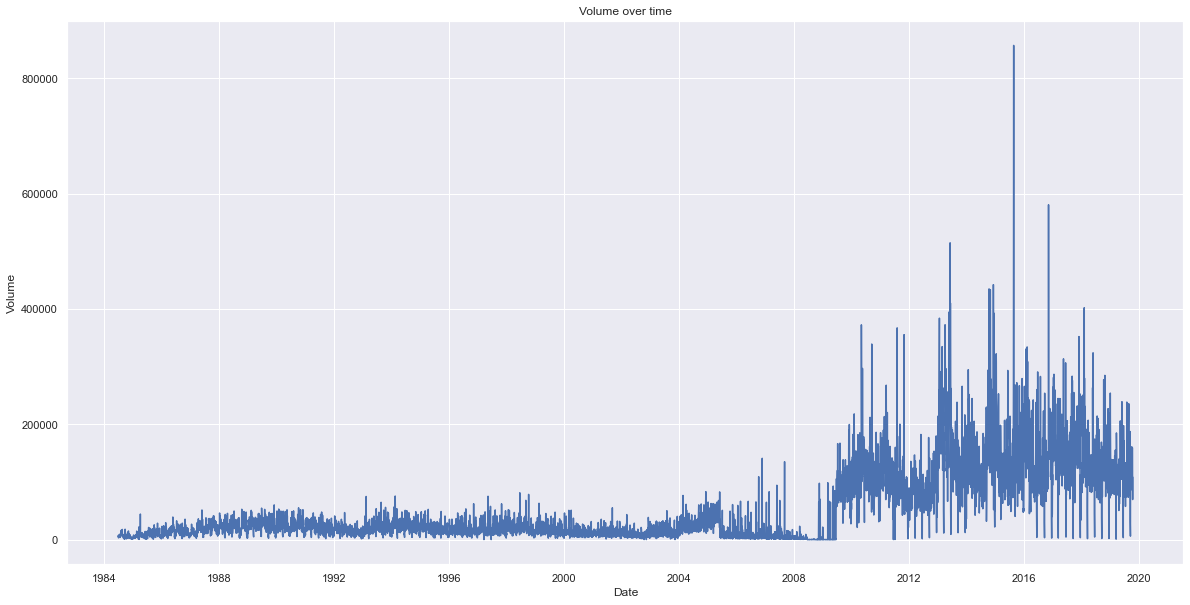

In [12]:
# Volume price over years

sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(x='Date', 
             y='Volume', data=yf)
plt.title("Volume over time")
plt.show()

# Return Forecasting: Initial Time-Series Plotting

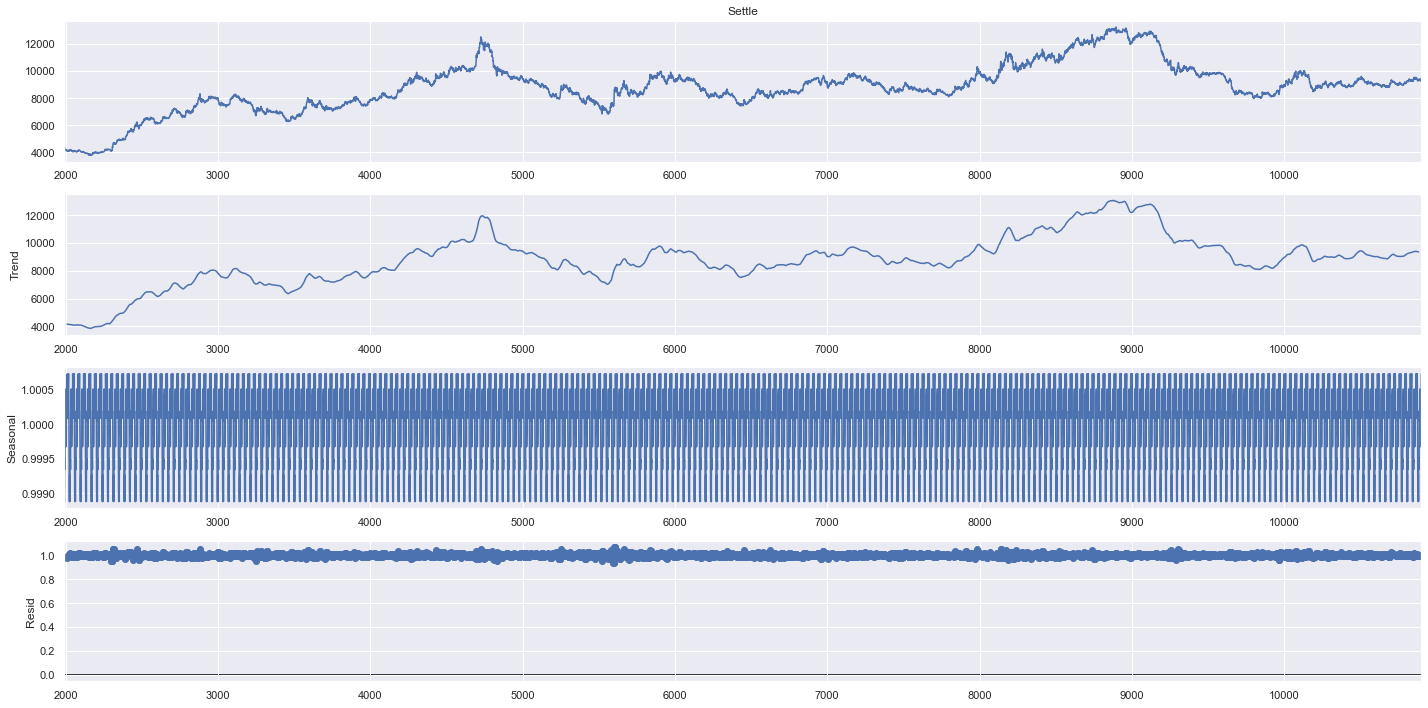

In [13]:
# Settle amount decomposition plot over 36 months

decomposition = seasonal_decompose(yf['Settle'], 
                                   model='multiplicative', 
                                   period=36)
decomposition.plot();

# Decomposition Using a Hodrick-Prescott Filter

In [14]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:

ts_noise, ts_trend = sm.tsa.filters.hpfilter(yf['Settle'])

In [15]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:

ds_yf = yf[['Settle']].copy()
ds_yf['noise'] = ts_noise
ds_yf['trend'] = ts_trend
ds_yf.tail()

,Settle,noise,trend
10897,9338,24.863582,9313.136418
10898,9304,-5.464543,9309.464543
10899,9251,-54.571292,9305.571292
10900,9265,-36.560812,9301.560812
10901,9222,-75.503142,9297.503142


<AxesSubplot:title={'center':'2015-Present: Settle vs. Trend'}>

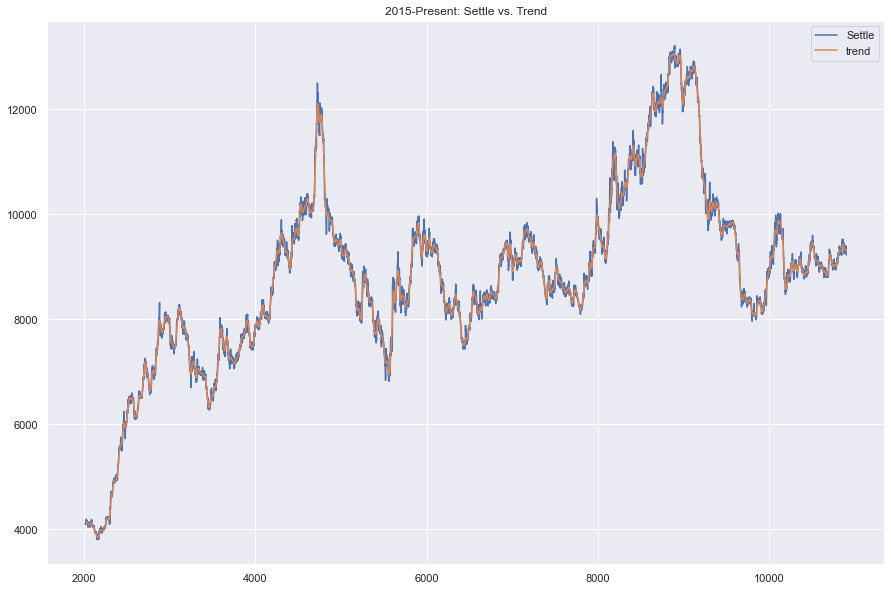

In [16]:
# Plot the Settle Price vs. the Trend for 2015 to the present

current_2015 = ds_yf.loc["2015":]
current_2015.plot(y=["Settle", "trend"], figsize=[15,10], title= "2015-Present: Settle vs. Trend")

<AxesSubplot:title={'center':'Noise'}>

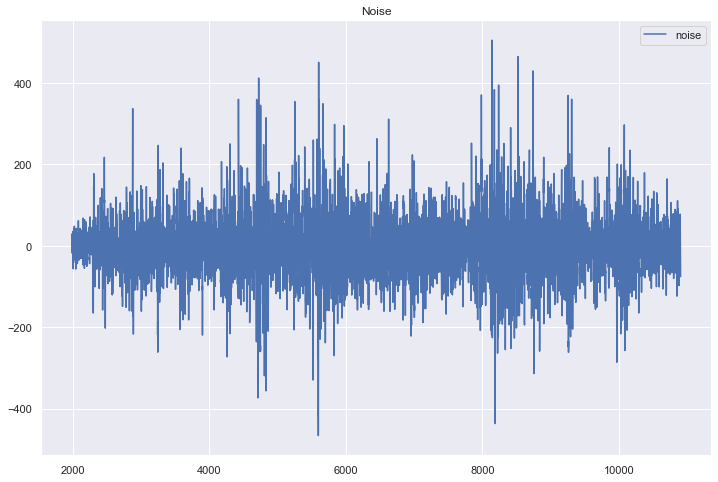

In [17]:
# Plot the Settle Noise

ds_yf.plot(y="noise", figsize=[12,8], title = "Noise")

# Forecasting Returns using an ARMA Model

Using futures Settle Returns, estimate an ARMA model

ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [18]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (ds_yf[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
10897,-0.405290
10898,-0.364104
10899,-0.569647
10900,0.151335
10901,-0.464112


<AxesSubplot:>

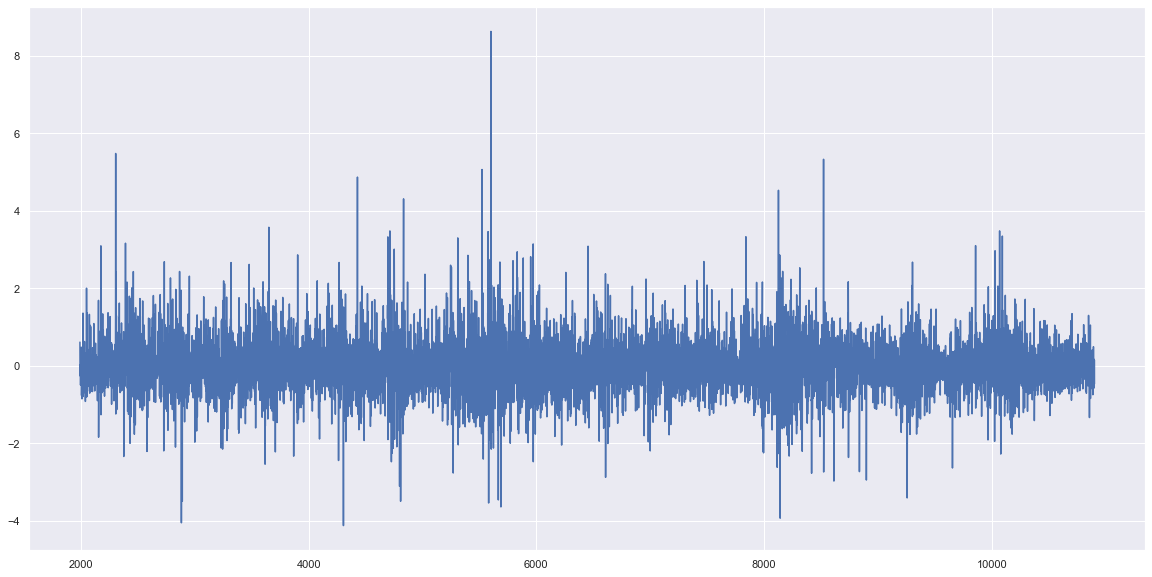

In [30]:
#Plot returns from "Settle"
returns.Settle.plot()

In [38]:
# Check data for stationarity

# Evaluating the descriptive statistics

values=returns.values

# getting the count to split the dataset into 3
parts = int(len(values)/3)
 
# splitting the data into three parts
p_1, p_2, p_3 = values[0:parts], values[parts:(
    parts*2)], values[(parts*2):(parts*3)]

m1,m2,m3=p_1.mean(),p_2.mean(),p_3.mean()

v1,v2,v3=p_1.var(),p_2.var(),p_3.var()

# printing the mean of three groups
print('mean1=%f, mean2=%f, mean2=%f' % (m1, m2, m3))
 
# printing the variance of three groups
print('variance1=%f, variance2=%f, variance2=%f' % (v1, v2, v3))

mean1=0.029471, mean2=0.000373, mean2=0.003408
variance1=0.508158, variance2=0.515117, variance2=0.416811


In [45]:
# Augmented Dickey Fuller Test

from statsmodels.tsa.stattools import adfuller

result = adfuller(returns.Settle)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -95.119101
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [46]:
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model_ARMA = ARMA(returns.values, order=(2,1))
# Fit the model and assign it to a variable called results
result_ARMA = model_ARMA.fit()
# Output model summary results:
result_ARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 8910
Model:                     ARMA(2, 1)   Log Likelihood               -9373.479
Method:                       css-mle   S.D. of innovations              0.693
Date:                Sun, 13 Feb 2022   AIC                          18756.957
Time:                        00:18:34   BIC                          18792.432
Sample:                             0   HQIC                         18769.034
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0110      0.008      1.315      0.189      -0.005       0.027
ar.L1.y        0.9692      0.028     34.902      0.000       0.915       1.024
ar.L2.y        0.0108      0.011      1.012      0.312      -0.010       0.032
ma.L1.y       -0.9772      0.026    -38.040      0.000      -1.028      -0.927
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0202           +0.0000j            1.0202            0.0000
AR.2          -90.4650           +0.0000j           90.4650            0.5000
MA.1            1.0233           +0.0000j            1.0233            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

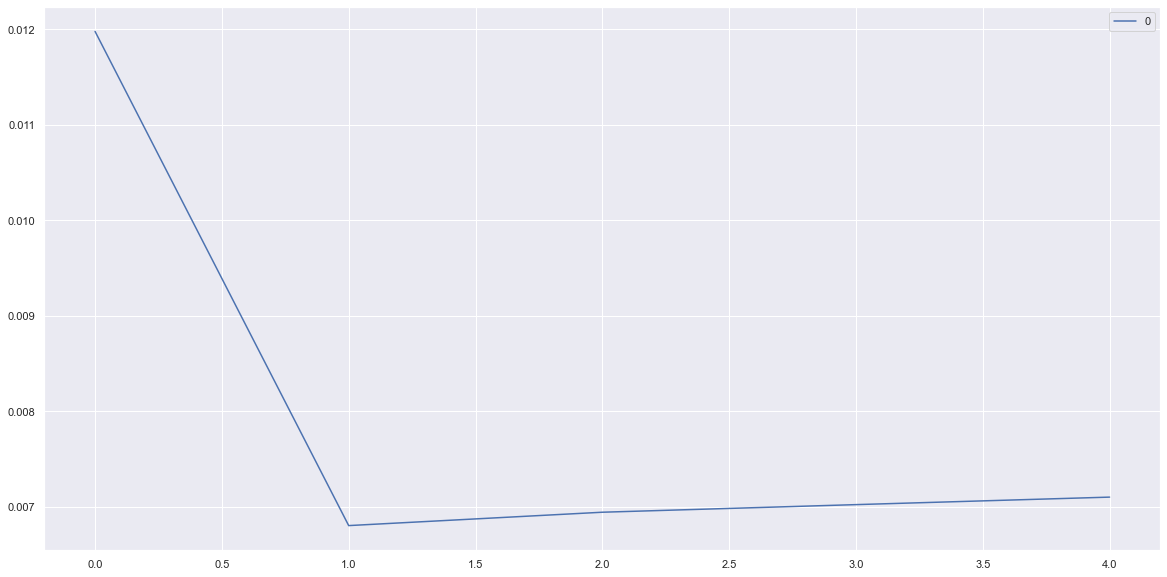

In [57]:
r=pd.DataFrame(result_ARMA.forecast(steps=5)[0])
r.plot()

# Forecasting the Settle Price using an ARIMA Model

Using the raw Yen Settle Price, estimate an ARIMA model.
Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [58]:
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model_ARIMA = ARIMA(returns.values, order=(5,1,1))
# Fit the model and assign it to a variable called results
result_ARIMA = model_ARIMA.fit()
# Output model summary results:
result_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 8909
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -9375.767
Method:                       css-mle   S.D. of innovations              0.693
Date:                Sun, 13 Feb 2022   AIC                          18767.534
Time:                        00:37:34   BIC                          18824.292
Sample:                             1   HQIC                         18786.857
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.893e-06   2.82e-06     -1.736      0.083   -1.04e-05    6.32e-07
ar.L1.D.y     -0.0076      0.011     -0.720      0.472      -0.028       0.013
ar.L2.D.y      0.0002      0.011      0.023      0.981      -0.021       0.021
ar.L3.D.y      0.0003      0.011      0.025      0.980      -0.020       0.021
ar.L4.D.y     -0.0168      0.011     -1.589      0.112      -0.038       0.004
ar.L5.D.y     -0.0005      0.011     -0.047      0.963      -0.021       0.020
ma.L1.D.y     -0.9999      0.000  -2732.581      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9658           -1.9222j            2.7494           -0.1232
AR.2            1.9658           +1.9222j            2.7494            0.1232
AR.3           -1.9575           -2.0061j            2.8029           -0.3730
AR.4           -1.9575           +2.0061j            2.8029            0.3730
AR.5          -34.0034           -0.0000j           34.0034           -0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

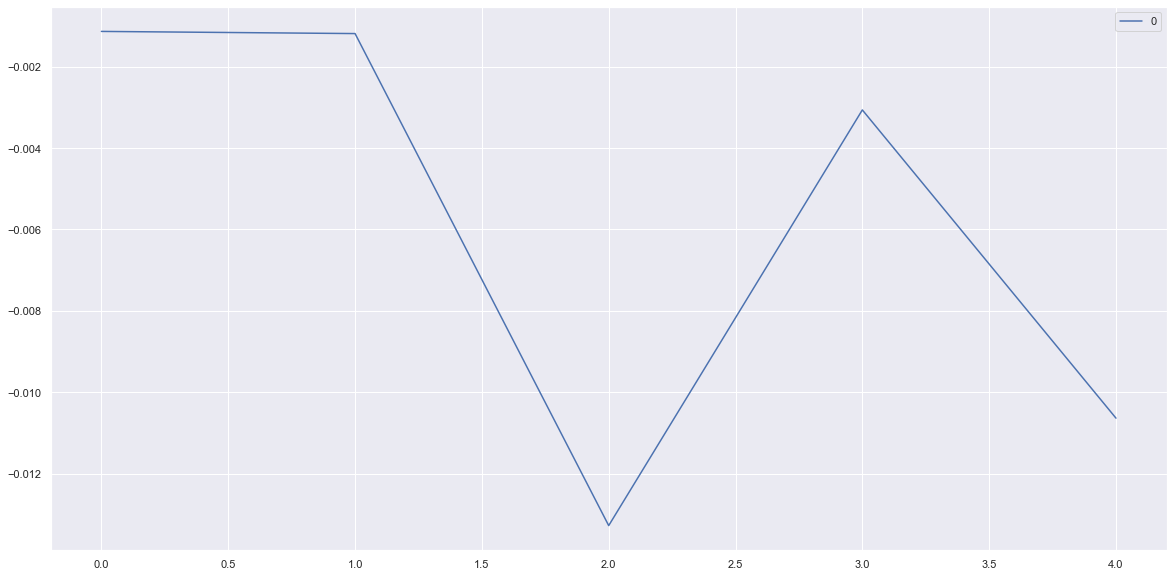

In [59]:
r=pd.DataFrame(result_ARIMA.forecast(steps=5)[0])
r.plot()

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term volatility of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.

Using futures Settle Returns, estimate an GARCH model

GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
Plot the 5-day forecast of the volatility.

In [4]:
pip install arch

  Using cached arch-5.1.0-cp38-cp38-win_amd64.whl (849 kB)
  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)
Note: you may need to restart the kernel to use updated packages.


In [19]:
from arch import arch_model

# Estimate a GARCH model:
model_GARCH = arch_model(returns.Settle, mean="Zero", vol="GARCH", p=2, q=1)
# Fit the model
results_GARCH = model_GARCH.fit(disp="off")

In [20]:
# Summarize the model results
results_GARCH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8932.17
Distribution:                  Normal   AIC:                           17872.3
Method:            Maximum Likelihood   BIC:                           17900.7
                                        No. Observations:                 8910
Date:                Mon, Feb 14 2022   Df Residuals:                     8910
Time:                        19:30:17   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.6967e-03  5.138e-03      1.498      0.134 [-2.375e-03,1.777e-02]
alpha[1]       0.0450  1.646e-02      2.734  6.250e-03  [1.275e-02,7.727e-02]
alpha[2]   5.1611e-14  2.416e-02  2.136e-12      1.000 [-4.735e-02,4.735e-02]
beta[1]        0.9398  2.827e-02     33.243 2.575e-242      [  0.884,  0.995]
=============================================================================

Covariance estimator: robust
"""

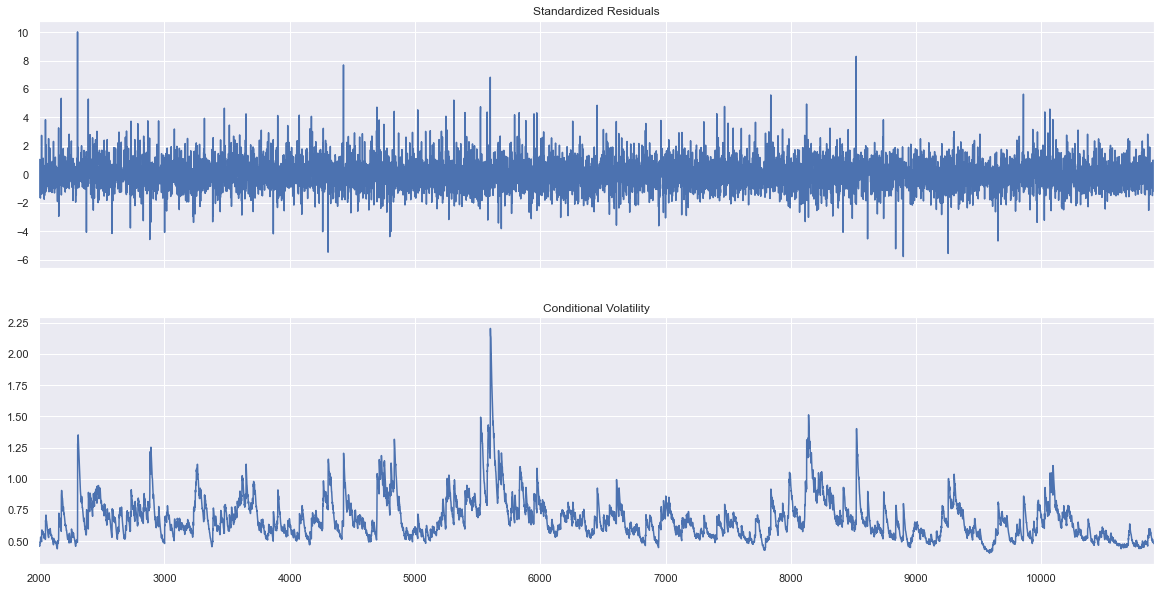

In [21]:
fig = results_GARCH.plot()

Based on the p-values, is the model a good fit (p < 0.05)?
Answer: Trading in derivatives will be more risky with time due to the YEN volatility increasing as shown in the plot above.

Based on your time series analysis, would you buy the yen now?
Is the risk of the yen expected to increase or decrease?
Based on the model evaluation, would you feel confident in using these models for trading?
Medium-to-risky investors should expect to BUY the yen now.
The YEN risk (volatility) is expected to increase along with the price.
ARIMA and GARCH; yes.